# Load test data

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load FFT features and labels
X_train = np.load("./fft_features/fft_features_train.npy")  # Shape: (samples, 2)
y_train = np.load("./labels/labels_train.npy")  # Labels: 0 = Dynamic, 1 = Static

X_test = np.load("./fft_features/fft_features_test.npy")  # Load new test dataset
y_test = np.load("./labels/labels_test.npy")  # Load test labels

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("\nTraining Data Label Distribution:")
for label, count in zip(unique_train, counts_train):
    print(f"Label {label} (0=Dynamic, 1=Static): {count}")

print("\nTest Data Label Distribution:")
for label, count in zip(unique_test, counts_test):
    print(f"Label {label} (0=Dynamic, 1=Static): {count}")

print("\nFirst 5 Samples from Training Data:")
for i in range(5):
    print(f"Sample {i}: Mean Freq = {X_train[i, 0]:.2f}, Dominant Freq = {X_train[i, 1]:.2f}, Label = {y_train[i]}")

print("\nFirst 5 Samples from Test Data:")
for i in range(5):
    print(f"Sample {i}: Mean Freq = {X_test[i, 0]:.2f}, Dominant Freq = {X_test[i, 1]:.2f}, Label = {y_test[i]}")

dynamic_train_freqs = X_train[y_train == 0, 1]  # Dominant frequencies of Dynamic gestures
static_train_freqs = X_train[y_train == 1, 1]  # Dominant frequencies of Static gestures

mean_dynamic_freq = np.mean(dynamic_train_freqs) if len(dynamic_train_freqs) > 0 else 0
mean_static_freq = np.mean(static_train_freqs) if len(static_train_freqs) > 0 else 0

print("\n⚠️ Label Flip Check:")
print(f"Mean Dominant Frequency (Dynamic): {mean_dynamic_freq:.2f} Hz")
print(f"Mean Dominant Frequency (Static): {mean_static_freq:.2f} Hz")

if mean_dynamic_freq < mean_static_freq:
    print("\nWARNING: Static gestures have a **higher** dominant frequency than dynamic! Labels might be flipped.")
    print("Try swapping 0 and 1 in y_train and y_test to see if accuracy improves.")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Training Data Label Distribution:
Label 0 (0=Dynamic, 1=Static): 561
Label 1 (0=Dynamic, 1=Static): 453

Test Data Label Distribution:
Label 0 (0=Dynamic, 1=Static): 810
Label 1 (0=Dynamic, 1=Static): 1080

First 5 Samples from Training Data:
Sample 0: Mean Freq = 3.58, Dominant Freq = 5.00, Label = 0
Sample 1: Mean Freq = 3.62, Dominant Freq = 1.00, Label = 0
Sample 2: Mean Freq = 3.70, Dominant Freq = 1.50, Label = 0
Sample 3: Mean Freq = 3.77, Dominant Freq = 2.50, Label = 0
Sample 4: Mean Freq = 3.39, Dominant Freq = 1.50, Label = 0

First 5 Samples from Test Data:
Sample 0: Mean Freq = 3.58, Dominant Freq = 1.50, Label = 0
Sample 1: Mean Freq = 3.56, Dominant Freq = 0.50, Label = 0
Sample 2: Mean Freq = 2.40, Dominant Freq = 0.50, Label = 0
Sample 3: Mean Freq = 3.57, Dominant Freq = 4.00, Label = 0
Sample 4: Mean Freq = 3.61, Dominant Freq = 2.00, Label = 0

⚠️ Label Flip Check:
Mean Dominant Frequency (Dynamic): 1.31 Hz
Mean Dominant Frequency (Static): 0.28 Hz


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")


Random Forest Accuracy: 0.40


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train model
clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

(1014, 2)
(1014,)
Logistic Regression Accuracy: 0.40


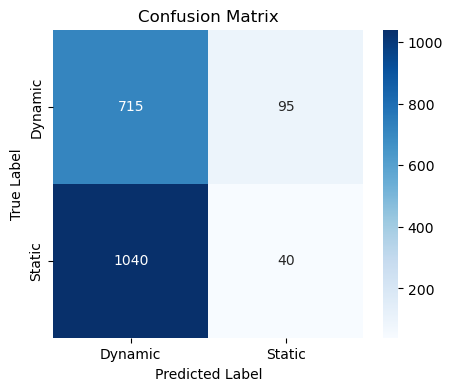

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dynamic", "Static"], yticklabels=["Dynamic", "Static"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


IndexError: list index out of range

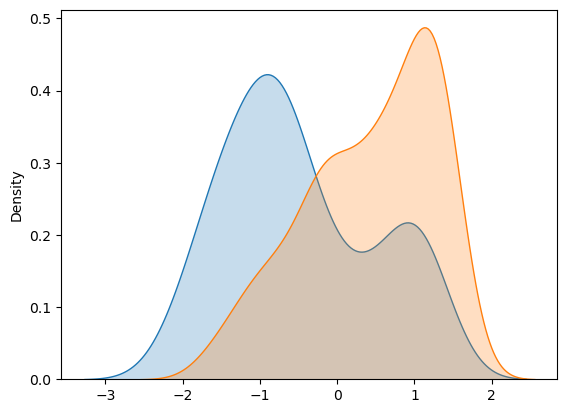

In [94]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated KDE curves from the density plot
dynamic_kde = sns.kdeplot(X_test[y_test == 1][:, 0], label="Dynamic Gestures", fill=True)
static_kde = sns.kdeplot(X_test[y_test == 0][:, 0], label="Static Gestures", fill=True)

# Extract density values and frequency points
dynamic_x, dynamic_y = dynamic_kde.get_lines()[0].get_data()
static_x, static_y = static_kde.get_lines()[1].get_data()

# Find intersection point (closest x where densities are equal)
intersection_index = np.argmin(np.abs(dynamic_y - static_y))
intersection_freq = dynamic_x[intersection_index]  # Frequency at intersection

print(f"Computed Intersection Frequency: {intersection_freq:.2f} Hz")

# Update classification function
def classify_gesture(mean_freq, dominant_freq):
    """Classify based on the intersection threshold."""
    return 0 if dominant_freq <= intersection_freq else 1

# Apply rule-based classification
y_pred_rule = np.array([classify_gesture(m, d) for m, d in X_test])

# Compute new accuracy
accuracy = np.mean(y_pred_rule == y_test) * 100
print(f"Updated Rule-Based Accuracy: {accuracy:.2f}%")

# Plot threshold for visualization
plt.axvline(intersection_freq, color='red', linestyle='dashed', label=f"Threshold: {intersection_freq:.2f} Hz")
plt.legend()
plt.show()
